# Photo-Z regression calculator
- Query training set of galaxies for which redshift (~distance measure) is available.
- Derive a k-nearest-neighbour regressor that determines redshift estimate from 5 "broad-band" magnitudes
- Test regressor against test set by plotting predicted vs actual redshift

## Author: Jake VanderPlas <vanderplas@astro.washington.edu>
## License: BSD
##   The figure is an example from astroML: see http://astroML.github.com

## Modified by: Dmitry Medvedev <dmedv@jhu.edu> to work with SDSS DB


In [2]:
# standard first block for defining the token and makinhg it available as a system variable for the session
# token must be replaced with new one once it has expired
with open('/home/idies/keystone.token', 'r') as f:
    token = f.read().rstrip('\n')# replace with your own token ID
import sys
sys.argv.append("--ident="+token)

In [5]:
import SciServer.CasJobs as CasJobs
from io import StringIO
import numpy as np
import pandas
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from astroML.plotting import scatter_contour

In [6]:
# some special settings
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')

In [7]:
NOBJECTS = 20000
GAL_COLORS_DTYPE = [('u', float),
                    ('g', float),
                    ('r', float),
                    ('i', float),
                    ('z', float),
                    ('redshift', float),
                    ('redshift_err', float)]

Now we do this

In [8]:
# get data from CasJobs
query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.z, s.zerr",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "   p.u BETWEEN 0 AND 19.6",
    "   AND p.g BETWEEN 0 AND 20",
    "   AND (s.class = 'GALAXY' OR s.class = 'QSO')")))
response = CasJobs.executeQuery(query_text, "DR12", token = token)
# read the result as a
output = StringIO(response.read().decode())
data = np.loadtxt(output, delimiter=',',skiprows=1, dtype=GAL_COLORS_DTYPE)

executeQuery POST response:  200 OK


In [29]:
# show some of the data
print(data[1:10])

[ (18.83112, 17.29024, 16.50008, 16.11667, 15.84818, 0.0782107, 2.577068e-05)
 (19.05429, 17.53863, 17.28942, 16.76724, 16.40356, 0.03804972, 8.51579e-06)
 (18.64129, 16.88924, 16.01846, 15.59155, 15.28224, 0.08794436, 2.157527e-05)
 (19.59348, 17.36073, 16.19878, 15.61329, 15.16467, 0.06480569, 2.268782e-05)
 (18.5298, 16.83844, 15.99536, 15.55486, 15.22578, 0.08297382, 1.623472e-05)
 (17.91679, 17.71118, 17.54662, 17.6206, 17.58281, 0.9855092, 0.0001681249)
 (17.84981, 17.61697, 17.55898, 17.67929, 17.50808, 0.8299965, 0.0001121338)
 (18.7498, 17.71191, 17.1269, 16.70263, 16.56216, 0.09988046, 7.11508e-06)
 (16.48823, 15.04822, 14.34598, 13.95731, 13.65474, 0.02533082, 1.154724e-05)]


In [12]:
n_neighbors = 1

N = len(data)

# shuffle data
np.random.seed(0)
np.random.shuffle(data)

# put colors in a matrix
X = np.zeros((N, 4))
X[:, 0] = data['u'] - data['g']
X[:, 1] = data['g'] - data['r']
X[:, 2] = data['r'] - data['i']
X[:, 3] = data['i'] - data['z']
z = data['redshift']

# divide into training and testing data
Ntrain = N / 2
Xtrain = X[:Ntrain]
ztrain = z[:Ntrain]

Xtest = X[Ntrain:]
ztest = z[Ntrain:]

knn = KNeighborsRegressor(n_neighbors, weights='uniform')
zpred = knn.fit(Xtrain, ztrain).predict(Xtest)

rms = np.sqrt(np.mean((ztest - zpred) ** 2))
print("RMS error = %.2g" % rms)

RMS error = 0.36


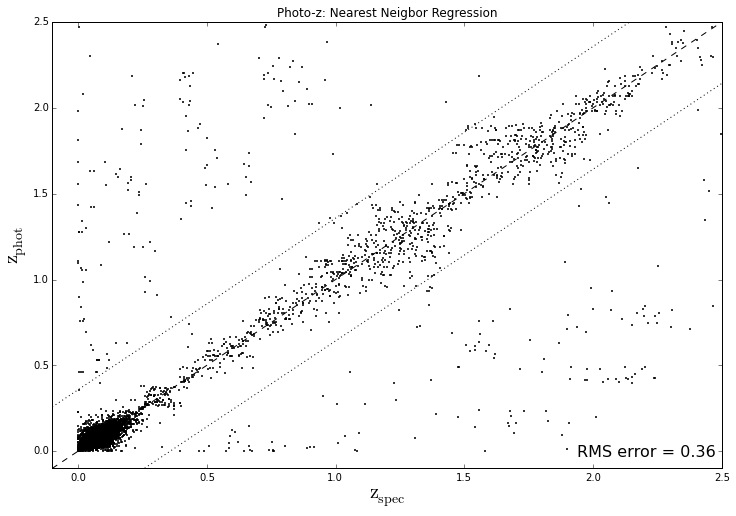

In [26]:
axis_lim = np.array([-0.1, 2.5])

plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.scatter(ztest, zpred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)

plt.text(0.99, 0.02, "RMS error = %.2g" % rms,
         ha='right', va='bottom', transform=ax.transAxes,
         bbox=dict(ec='w', fc='w'), fontsize=16)

plt.title('Photo-z: Nearest Neigbor Regression')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=20)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=20)
plt.show()